# Platform Positioning

In [19]:
from __future__ import print_function

In [20]:
import random as random #For random initial platform position
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point, LineString 
import shapely
from geopy import distance # For calculating distance between two points 


import pickle  as pkl # For importing pickled objects

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import tan, isclose, pi #F or calculating point on circumference - step out radius

# Ingest Processed Data
### Target Polygons
These were processed in the preceeding notebook and stored in '1_processed'

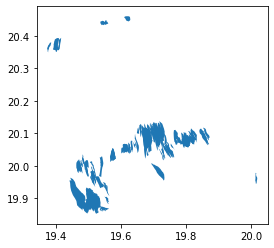

In [21]:
with open('data/1_processed/target_polygon_gdf.pkl', 'rb') as f:
    gdf_targPoly = pkl.load(f)
    
gdf_targPoly.plot()

### Well Concepts
As no suitable test data exists, dummy data is generated. There is a separate dummdatacreator.py file containing this work.

Rather than have Well Concepts randomly placed anywhere, we restrict it to only be within Target Polygon space

In [22]:
from dummydatacreator import  GenerateMultipleWellConceptsTEST as GenerateWCs # This is not supported in Azure notebooks

In [23]:
lon_min = 19.35
lon_max = 19.9 
lat_min = 19.8 
lat_max = 20.4
n_concepts = 70
WC_name, WC_points, WC_resource = GenerateWCs(gdf_targPoly,n_concepts = n_concepts, lon_min =lon_min, lon_max = lon_max, lat_min =lat_min, lat_max = lat_max)

print("Well Concepts Generated:\n",'\n'.join('Name: {}, Points: {}, Resource: {}'.format(WC_name[k], WC_points[k], WC_resource[k]) for k in range(5)))

Well Concepts Generated:
 Name: X-2, Points: [19.540895439062265, 20.01725884283493], Resource: 116.54960912963689
Name: Lc-235, Points: [19.458216427813248, 19.921077119282938], Resource: 142.45407556495357
Name: O-655, Points: [19.756791888170675, 20.056367289667552], Resource: 20.066390403667143
Name: M-428, Points: [19.6923183702778, 20.04824184833345], Resource: 72.25820827319212
Name: X-167, Points: [19.50782052680041, 19.894875721120215], Resource: 66.34962047090922


# Mapping
In order to construct the map containing Targets, Well Concepts, Platforms, some functions are required:


### Platform Step-Out Radius Functions
As there is no method for deriving the circumference around a point in EPSG:4326, functions are required to calculate this.
- A function to find a single point on the circumference (within a given tolerance)
- A function to find multiple points all around the circumference, sufficient for plotting the circle

In [24]:
def GetXYatCircumference(centre, desired_radius, theta, tolerance = 0.00001):
    '''Calculates the X,Y coordinates of a point on the circumference of a circle, 
    with a given desired radius and angle to the vertical.
    
    Theta in radians
    '''
    
    #Initialise x,y coordinates
    x = centre[0]
    y = centre[1]

    
    #Set initial increment values
        #If we are working in the lower two quadrants, i.e. where y will be less than centre y
    if theta > pi/2 and theta < (3*pi)/2:
        y_increment=-0.01
    else:
        y_increment=0.01

        
    #Loop until the radius of the point and centre, is close to the desired radius
    while isclose(distance.distance(centre, [x,y]).kilometers,  desired_radius ,rel_tol=0.00001) == False:

        # Add the increment whilst the distance is less than desired
        while distance.distance(centre, [x,y]) < desired_radius:
            x_increment = y_increment * tan(theta)
            x += x_increment
            y += y_increment

        # Subtract the increment whilst the distance is more than desired
        while distance.distance(centre, [x,y]) > desired_radius:
            x_increment = y_increment * tan(theta)
            x -= x_increment
            y -= y_increment

        #Reduce the size of the increment to increase precision  
        y_increment = y_increment/4

    return [x,y]

In [25]:
def GetCircumferenceXY(centre, radius, n_points, tolerance = 0.00001):
    '''Calculates x,y coordinates of a specified number points on the circumference of a 
    circle with a specified centre    
    
    NB: n_points must odd, to ensure we do not get a trig erro
    '''
    assert n_points % 2 != 0, "n_points must not be an even number - gives a trig error"

    # The angle between each radius        
    theta_increment = (2*pi)/n_points

    # The angles of all the radii we will use
    thetas = [theta_increment * i for i in range(n_points)]
    
    # Get a list of all calculated XYs on the circumference
    xys = [GetXYatCircumference(centre, radius,theta_i,tolerance) for theta_i in  thetas]
    
    # Create a full 'loop' so the first and last points are the same - Polygon
    xys.append(xys[0])
    
    
    xs = [xy[0] for xy in xys]
    ys = [xy[1] for xy in xys]
    
    return xs, ys

GetCircumferenceXY([0,0], 2, 3)

([0.0, 0.015637707705740515, -0.015637707705740488, 0.0],
 [0.01796615600585938,
  -0.009028434753417969,
  -0.009028434753417969,
  0.01796615600585938])

### Well Concept Relative Position
i.e. Are Well Concepts within specified radii around a point?

In [26]:
def BinByDistances(pointsToRank, centre, distBins):
    '''Well Concepts are ranked according to binned distance from platform. i.e. 
    Given input distances [0,2,5], the function will return a list of rankings where:
    0 indicates Well Concept is more than 5 km from platform
    1 indictates Well Concept is between 2 and 5 km from platform... etc
    '''
    #Radii must be ordered, i.e. [0,2,5]
    distBins = np.sort(distBins)
    
    num_bins = len(distBins)

    #calculate distances of all well concepts from platform 
    distances = [distance.distance(point_i, centre) for point_i in pointsToRank] #Karney 2013 distance
    
    distances = np.reshape(distances,[-1])

    
    #Reverse ranking - where 0 is closest to platform
    revranks = np.digitize(distances, distBins, right = False) #i.e. includes left bound = 0

    # Ranking - where 0 is furthest from platform
    ranking = [num_bins - revrank for revrank in revranks]
    
    return ranking

In [27]:
dct_colors = {0: "#808080",
          1:"#FF8000",
          2:"#00CC00"}

In [28]:
def GetWCRanks(wcpoints, plat_points,radii):
    '''
    Given the rank of Well Concepts, this derives the appropriate color for them
    
    If a WC has a rank of 3 (i.e. very close) with a platform, but a rank of 0 (i.e. far) from another platform, we 
    only care about the ranking of 3
    '''
    #Subset the WCs to only those which are on the creaming curve
    #A list for each platform, in which each WC is given a rank/bin
    WC_rank_by_platform = []
    
    for plat_point in plat_points:
        WC_rank_by_platform.append(BinByDistances([(a[0], a[1]) for a in wcpoints],plat_point,radii) )

    WC_best_rank = [max(WC_ranks)   for WC_ranks in zip(*WC_rank_by_platform)]
    
    
    return WC_best_rank  

## Map Construction

https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9

In [29]:
import json
from bokeh.models.widgets import Slider

from bokeh.io import output_file, show, save

from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool, LabelSet,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
# Input GeoJSON source that contains features for plotting
from bokeh.models.markers import SquareCross
from bokeh.models.callbacks import CustomJS


from bokeh.layouts import column, row,grid, WidgetBox
from bokeh.models import Panel
from bokeh.models.widgets import Tabs

In [36]:


WC_name, WC_points, WC_resource = GenerateWCs(gdf_targPoly, n_concepts, lon_min, lon_max, lat_min, lat_max)

#Defaults
radiusinner=1.4
radiusouter=1.6





#Any calculations based on the above defaults
n_plat = 30
_, plat_points, _ = GenerateWCs(gdf_targPoly, n_plat, lon_min, lon_max, lat_min, lat_max)
plat_points = list(plat_points)
plat_name = ["Platform" for i in range(len(plat_points))]


_ = GetWCRanks(WC_points,plat_points, [0,radiusinner,radiusouter])
WC_colors = [dct_colors[wcrank] for wcrank in _]  




innerstepoutsx = []
innerstepoutsy = []

for plat_point in plat_points:
    innerstepoutx, innerstepouty = GetCircumferenceXY(plat_point,radiusinner , 401)
    innerstepoutsx.append(np.array(innerstepoutx[:-1]))
    innerstepoutsy.append(np.array(innerstepouty[:-1]))

outerstepoutsx = []
outerstepoutsy = []

for plat_point in plat_points:
    outerstepoutx, outerstepouty = GetCircumferenceXY(plat_point,radiusouter , 401)
    outerstepoutsx.append(np.array(outerstepoutx[:-1]))
    outerstepoutsy.append(np.array(outerstepouty[:-1]))
    


In [37]:
plat_points

[[19.816874653949373, 20.099038604968023],
 [19.737031011942907, 20.07782274711916],
 [19.728045304288887, 20.08771091892368],
 [19.57776225558882, 20.0249195447819],
 [19.44907576217978, 19.91920385958667],
 [19.67874277588574, 20.07381502051701],
 [19.732141957087038, 20.061332661123828],
 [19.493409020007253, 19.86744266452775],
 [19.509561677587804, 19.90364184926796],
 [19.486010163830773, 19.89542195082485],
 [19.690014140734235, 20.077106003177505],
 [19.82621019028358, 20.103045568660587],
 [19.615937423647726, 20.06366908001105],
 [19.523740757400112, 19.86728565701641],
 [19.548356714007994, 19.870292214278596],
 [19.61475297766508, 20.066246362854432],
 [19.77891337035661, 20.07956871407455],
 [19.532082783341924, 19.94773771550776],
 [19.815601756055912, 20.092855346427356],
 [19.454448772283243, 19.910217439860805],
 [19.729784445585647, 20.078200745730207],
 [19.499637170537138, 19.97038955629334],
 [19.70429798672904, 20.104065738013936],
 [19.505439676603967, 19.9200812

### Bokeh Map

In [54]:


# Create figure object.
p = figure(title = 'Polygon Map', 
           plot_height = 700 ,
           plot_width = 700, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
           active_scroll = "wheel_zoom",
            x_range=(lon_min, lon_max),
            y_range=(lat_min, lat_max),          
          )
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None



# TARGET LAYER #
# Data Source
ds_targ = GeoJSONDataSource(geojson = gdf_targPoly[['target_id', 'target_name', 'polygon']].to_json())

# Bokeh Layer
p_targ = p.patches('xs','ys', source = ds_targ,
                   fill_color = "lightskyblue",
                   line_color = "blue", 
                   line_width = 0.1, 
                   fill_alpha = 0.2)


#PLATFORM LAYER #
platx = [a[0] for a in plat_points]
platy = [a[1] for a in plat_points]


# Data Source 
ds_plat = ColumnDataSource({'x':platx, 'y':platy, 'name': plat_name})
# Bokeh Layer
p_plat = p.diamond_cross("x", "y", size=20, source=ds_plat,
         line_color="black", fill_alpha=0.8)
# Label layer
labels = LabelSet(x="x", y="y", text="name", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=ds_plat, text_align='center')
p.add_layout(labels)


#PLATFORM INNER STEP-OUT INNER #
#Data Source
source_step_inner = ColumnDataSource({'x':innerstepoutsx, 'y':innerstepoutsy})

#Bokeh layer
p_step_inner = p.patches('x','y', source = source_step_inner,
                   fill_color = None,
                   line_color = "#00CC00", 
                   line_width = 2, 
                   fill_alpha = 1)

#PLATFORM STEP-OUT OUTER #
source_step_outer = ColumnDataSource({'x':outerstepoutsx, 'y':outerstepoutsy})

p_step_outer = p.patches('x','y', source = source_step_outer,
                   fill_color = None,
                   line_color = "#FF8000", 
                   line_width = 1, 
                   fill_alpha = 0.1)

# WELL CONCEPTS
wcx = [a[0] for a in WC_points]
wcy = [a[1] for a in WC_points]
ds_wc = ColumnDataSource({'x':wcx, 'y':wcy, 'name':WC_name, 'resource':WC_resource, 'hex': WC_colors})

p_wc = p.circle("x", "y", size=5, source=ds_wc,
         color='hex', line_color="black", fill_alpha=0.8)

labels = LabelSet(x="x", y="y", text="name", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=ds_wc, text_align='center')
p.add_layout(labels)

# Create hover tool
p.add_tools(HoverTool(renderers = [p_wc],
                      tooltips = [('Well Concept','@name'),
                                ('Resource','@resource')]))

### MPL Bar Chart - Creaming Curve

In [55]:
#Subset the WCs to only those which are on the creaming curve
WC_rank = GetWCRanks([(a[0], a[1]) for a in WC_points],plat_points,[0,radiusinner, radiusouter])

#Construct dataframe of all well concepts
df_WC = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource, "Rank":WC_rank, \
                      "x":[c[0] for c in WC_points],  "y":[c[1] for c in WC_points]})

#Reduce to df of well concepts on Creaming Curve (i.e. within the radii)
df_WC_cc = df_WC[df_WC['Rank'] != 0].copy()

#Map ranks to colors
df_WC_cc.loc[:,'Color'] = df_WC_cc['Rank'].map(lambda x: dct_colors[x])

df_WC_cc.sort_values(by="Resource", inplace=True, ascending=False)

b = figure(x_range=df_WC_cc['Well Concept'], plot_height=250, title="All Accessible Wells")
b.vbar(x=df_WC_cc['Well Concept'], top=df_WC_cc['Resource'], color=df_WC_cc['Color'], width=0.9)

b.xgrid.grid_line_color = None
b.y_range.start = 0

In [56]:
all_name, all_res, all_col, x, y = df_WC_cc[['Well Concept', 'Resource', 'Color', 'x', 'y']].T.values

dct_wc = {'name':all_name.tolist(), 'resource':all_res.tolist(), 'color':all_col.tolist(), 'x':x, 'y':y}

cds_visibleWC = ColumnDataSource(dct_wc)

d = figure(x_range=all_name, plot_height=250, title="Visible, Accessible Wells")
d.vbar(x='name', top='resource', color='color', source=cds_visibleWC, width=0.9)



GlyphRenderer(id='4126', ...)

### Create Bokeh Layout

In [57]:
output_file("Dashboard.html")

# CHANGE IN X RANGE FORCES A RECALC OF ALL VISIBLE WELL CONCEPTS
p.x_range.callback = CustomJS(
        args=dict(source=cds_visibleWC, allwc=dct_wc ), code=
"""
var data = source.data;
let visiblewc = [];
let visibleres = [];
let visiblecol = [];
let visiblex = [];
let visibley = [];

console.log(allwc);
console.log(data);

for (let i = 0; i < allwc.x.length; i++){

    if (allwc.x[i] > cb_obj.start && allwc.x[i] < cb_obj.end){
        visiblex.push(allwc.x[i]);
        visibley.push(allwc.y[i]);
        visiblewc.push(allwc.name[i]);
        visibleres.push(allwc.resource[i]);
        visiblecol.push(allwc.color[i]);      
    }
}

//callback object - i.e. x_range
data.x = visiblex;
data.y = visibley;
data.name = visiblewc;
data.resource = visibleres;
data.color = visiblecol;

source.change.emit();
""")


# CHANGE IN Y RANGE  JUST SUBSETS EXISTING CC
p.y_range.callback = CustomJS(
        args=dict(source=cds_visibleWC ), code=
"""
var data = source.data;
let visiblewc = [];
let visibleres = [];
let visiblecol = [];
let visiblex = [];
let visibley = [];


for (let i = 0; i < data.y.length; i++){
    if (data.y[i] > cb_obj.start && data.y[i] < cb_obj.end){
        visiblex.push(data.x[i]);
        visibley.push(data.y[i]);
        visiblewc.push(data.name[i]);
        visibleres.push(data.resource[i]);
        visiblecol.push(data.color[i]);      
    }
}

//callback object - i.e. x_range
data.x = visiblex;
data.y = visibley;
data.name = visiblewc;
data.resource = visibleres;
data.color = visiblecol;

source.change.emit();
""")


# Create a row, with control panel and plot
layout = grid(row(p, column(b, d)))

# Make a tab with the layout 
tab = Panel(child=layout, title = 'Geospatial PoC')
tabs = Tabs(tabs=[tab])
save(tabs)

'/Users/Pri.balachandran@ibm.com/Desktop/BP/20191106_PlatformWCAnalysis/Dashboard.html'